<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/Copy_of_Pi_CNN_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:

# visualization tools
import matplotlib.pyplot as plt

# torch- Our deep learning framework
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
import math

# from other notebooks
# import import_ipynb
# from dataloaders import DataLoader

In [29]:
# Define the transformations
transform = transforms.Compose([
    ToTensor(),
    transforms.Normalize(mean=[0.1310], std=[0.3085])
])

# Load the training data
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True,
)

# Load the test data
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transform,
)

In [30]:
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PiCon2D(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,pool_kernel_size=2, padding=0):
        super(PiCon2D, self).__init__()
        self.kernel_size = (kernel_size, kernel_size)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.padding = padding
        self.pool_kernel_size = (pool_kernel_size,pool_kernel_size)

        # Initialize weights
        # DO NOT STORE WEIGHT EXTERNALLY YOU NEED MORE FOR MORE THAN ONE LAYER
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))

        # self.bias = nn.Parameter(torch.Tensor(out_channels))

        # Apply Kaiming uniform initialization to the weights
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

        # Initialize the bias to zeros
        # fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        # bound = 1 / math.sqrt(fan_in)
        # nn.init.uniform_(self.bias, -bound, bound)

        # Define an activation function (ReLU in this case)
        self.activation = nn.ReLU()

        # Define a max-pooling layer
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size)

        # To store the feature maps
        self.feature_maps = None



    def pi_conv2d(self, input, weight, stride=1, padding=0):
      batch_size, in_channels, in_h, in_w = input.shape
      out_channels, _, kh, kw = weight.shape

       # Calculate output dimensions
      out_h = (in_h + 2 * padding - kh) // stride + 1
      out_w = (in_w + 2 * padding - kw) // stride + 1

      # Unfold input tensor
      unfold = torch.nn.Unfold(kernel_size=(kh, kw), stride=stride, padding=padding)

      inp_unf = unfold(input)  # Shape: [batch_size, in_channels * kh * kw, out_h * out_w]


      # Reshape weight for matrix multiplication
      in_channels = weight.size(1)
      w_ = weight.view(out_channels, in_channels * kh * kw)  # Shape: [out_channels, in_channels * kh * kw]


      # Apply absolute value and logarithmic transformation with clamping
      abs_inp_unf = torch.abs(inp_unf)
      log_abs_inp_unf = torch.log(abs_inp_unf)  # Logarithm with clamping

      # Matrix multiplication for positive values
      log_abs_inp_unf_t = log_abs_inp_unf.transpose(1, 2)  # Shape: [batch_size, out_h * out_w, in_channels * kh * kw]
      sum_log = torch.matmul(log_abs_inp_unf_t, w_.t())  # Compute sum of logs
      # sum_log = torch.clamp(sum_log, min=-50, max=50)  # Clamping to prevent overflow in exp
      part_one = torch.exp(sum_log)  # Shape: [batch_size, out_h * out_w, out_channels]

      # Create a mask for negative values (for weights)
      negative_mask = (inp_unf < 0).float()

      # Compute the sum of weights where inputs are negative
      sum_weights = torch.matmul(negative_mask.transpose(1, 2), w_.t())  # Shape: [batch_size, out_h * out_w, out_channels]
      cos_w = torch.cos(math.pi * sum_weights)  # Shape: [batch_size, out_h * out_w, out_channels]

      # part_two should have the same shape as part_one
      part_two = part_one * cos_w  # Shape: [batch_size, out_h * out_w, out_channels]


      # Align positive mask dimensions for element-wise operations
      positive_mask = (inp_unf > 0)  # Remove unsqueeze here

      # Expand positive_mask correctly to 3D and match output channels
      positive_mask = positive_mask.transpose(1, 2)  # Shape: [batch_size, out_h * out_w, in_channels * kh * kw]
      positive_mask = positive_mask[..., :1]  # Reduce to only one dimension before expanding
      positive_mask = positive_mask.expand(batch_size, out_h * out_w, out_channels)  # Shape: [batch_size, out_h * out_w, out_channels]

     # Apply torch.where with correctly aligned tensors
      out = torch.where(positive_mask, part_one, part_two)  # Ensure the shapes match
      out = out.view(batch_size, out_channels, out_h, out_w)  # Reshape back to 4D tensor

      # Store the feature maps
      self.feature_maps = out

      return out


    def forward(self, x):
       # Apply PiConv2D for feature extraction

        y = self.pi_conv2d(x, self.weight, self.stride, self.padding)  # Feature extraction
        z = nn.Conv2d(self.in_channels, self.out_channels, 3, self.stride,self.padding)
        z_out = z(x)
        combined = torch.cat((y, z_out), dim=1)  # Concatenate along the channel dimension
        combined = combined.view(combined.size(0), -1)
        out =self.activation(combined)
        out = out.view(out.size(0), -1)  # Flatten the tensor
        in_features = out.size(1)  # Dynamically set input size)

        # Define the fully connected layers with the concatenated input
        fc = nn.Sequential(
            nn.Linear(in_features, 128),  # in_features is dynamically set
            nn.ReLU(),
            nn.Linear(128, 10)  # Output size is 10 for 10 classes (digits 0-9)
        )
        # Pass the concatenated features through the fully connected layers
        output  = fc(combined)

        return F.log_softmax(output , dim=1)  # Softmax activation for classification


In [32]:

model = PiCon2D(1,32)

In [33]:
# loss function
loss_func = nn.CrossEntropyLoss()

In [34]:
# Adam optimizer
# optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [35]:
def train(epoch):
    model.train()
    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data, target

        output = model(data)

        # Ensure output shape: [batch_size, num_classes]
        # Ensure target shape: [batch_size] with class indices

        # Calculate loss
        loss = loss_func(output, target)
        loss.backward()
       #Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()


        train_loss += loss.item()

        # Calculate accuracy
        _, pred = output.max(1)  # Get the predicted class
        train_acc += target.eq(pred).sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)  # Correctly normalize accuracy

    return train_loss, train_acc * 100  # Convert accuracy to percentage


In [36]:
def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(test_loader.dataset)
    return val_loss, val_acc

In [37]:
# check if the weights are not zeros or too close to zero


# print("Min value in weights:", model.weight.min().item())
# print("Max value in weights:", model.weight.max().item())

Checking and printing the features

In [38]:
# print("Min value in feature maps:", feature_maps.min().item())
# print("Max value in feature maps:", feature_maps.max().item())


In [39]:
# # Pass a batch of images through the model
# data_iter = iter(train_loader)
# images, labels = next(data_iter)  # Use next() function instead of .next()

# # Get the model output
# output = model(images)

# # Get the feature maps from the model
# feature_maps = model.feature_maps

# # Plot the feature maps
# def plot_feature_maps(feature_maps, n_cols=8):
#     n_filters = feature_maps.shape[1]
#     n_rows = (n_filters + n_cols - 1) // n_cols

#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2))
#     for i in range(n_rows):
#         for j in range(n_cols):
#             idx = i * n_cols + j
#             if idx < n_filters:
#                 ax = axes[i, j]
#                 ax.imshow(feature_maps[0, idx].detach().cpu().numpy(), cmap='viridis')
#                 ax.axis('off')
#             else:
#                 axes[i, j].axis('off')
#     plt.show()

# plot_feature_maps(feature_maps)


In [40]:
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))
    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)
    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

--- Epoch 1 ---
	Train loss: 2.3220, acc: 9.7883%
	Val loss: 2.3255, acc: 0.0905%
--- Epoch 2 ---
	Train loss: 2.3187, acc: 10.1167%
	Val loss: 2.3179, acc: 0.1054%
--- Epoch 3 ---
	Train loss: 2.3161, acc: 10.1500%
	Val loss: 2.3166, acc: 0.0942%
--- Epoch 4 ---
	Train loss: 2.3188, acc: 9.9267%
	Val loss: 2.3147, acc: 0.1061%
--- Epoch 5 ---
	Train loss: 2.3162, acc: 10.2750%
	Val loss: 2.3146, acc: 0.1040%
--- Epoch 6 ---
	Train loss: 2.3170, acc: 10.0567%
	Val loss: 2.3194, acc: 0.0988%
--- Epoch 7 ---
	Train loss: 2.3161, acc: 10.0333%
	Val loss: 2.3121, acc: 0.1059%
--- Epoch 8 ---
	Train loss: 2.3153, acc: 10.1733%
	Val loss: 2.3208, acc: 0.0962%
--- Epoch 9 ---
	Train loss: 2.3166, acc: 9.9217%
	Val loss: 2.3162, acc: 0.0978%
--- Epoch 10 ---
	Train loss: 2.3157, acc: 9.8683%
	Val loss: 2.3150, acc: 0.1016%


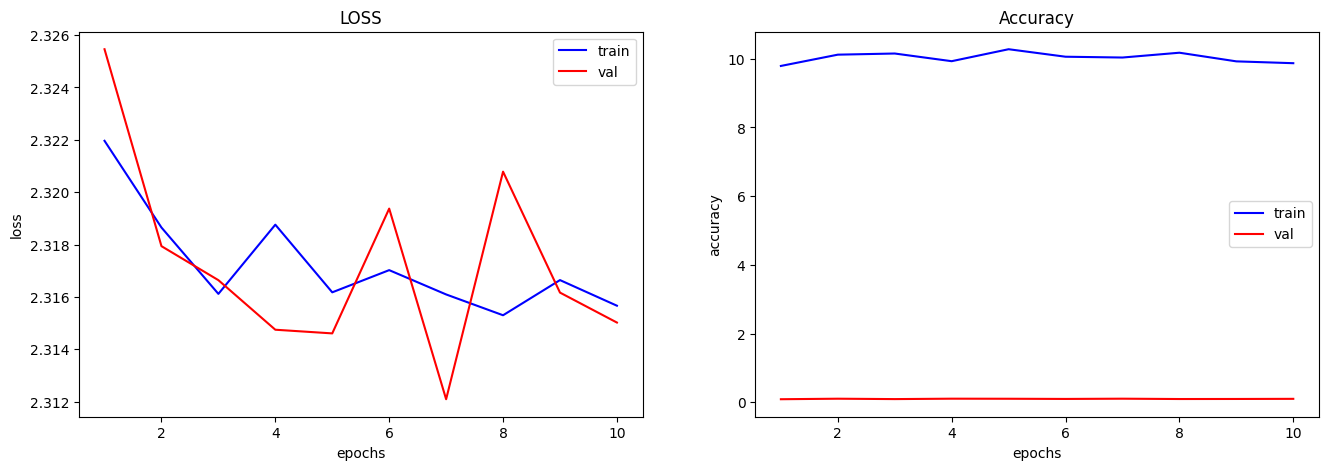

In [41]:
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()